# 1) Setup

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import math
import scipy as sp
from scipy import stats
from copy import copy
import time

import pymongo
from pymongo import MongoClient
from datetime import datetime
from datetime import timedelta
print("done")

done


In [58]:
#import functions from python files

#1) data import & filtering
from get_data import *
from filter_data1 import *
from filter_data2 import *
from filter_data3 import *
from select_data import *
from select_data_edge import *

#2) Bayesian: lognormal
from Gamma import *
from Lognormal import *

from Gaussian import *
from Gaussian_broadcast import *

from Normal_Gamma import *
from Normal_Gamma_bayes import *
from Normal_Gamma_bayes_update import *

#for comparison
from Gaussian_ml import *

from error_mae import *
from error_mse import *

from integrate_pdf import *
from error_ks import *                 #Kolmogorov-Smirnov
from error_ks_2samples import *


print("done")

done


In [3]:
# load from excel (see FILTER.ipynb)
df = pd.read_excel("filtered_data.xlsx")
df = df.loc[:,["origin", "target", "edge_id", "operation_time"]]
    
print("done")

done


# 2) Lognormal model
- if X is lognormally distributed, then ln(X) is normally distributed

## 2a) Fit using Bayesian optimisation
- Bayesian method uses an offset on the t-axis to allow the distribution to have greater skew. This operates in a similar fashion to a hard minimum t-value

In [49]:
# Select data of interest
wp1 = "WayPoint70"
wp2 = "WayPoint71"
edge = wp1 + "_" + wp2
subset = select_data_edge(df, edge)
#independent variable to plot over
t_op = subset["operation_time"]
print("done")

done


MAP mean: 0.356     MAP var: 1.779
Time for calculation: 16.66206383705139 secs


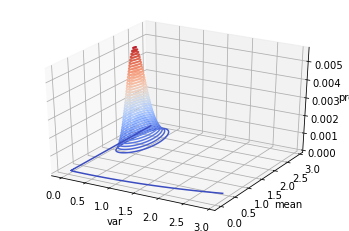

In [52]:
#use offset and take log of data
offset = np.min(t_op) - 0.001
t_log = np.log(t_op - offset)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)//5     
t_obs = t_log[0:n_terms]


#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test, var_test, posterior, mean_map, var_map = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b)
toc = time.time()
print("MAP mean:", mean_map, "    MAP var:", var_map)
print("Time for calculation:", toc-tic, "secs")

#store mean_map & mean_var for comparison
mean_map_old = mean_map
var_map_old = var_map

## 2b) Fit using MLE & Scipy for comparison

In [53]:
#compare to MLE mean & var
mean_ml, var_ml = Gaussian_ml(t_log)
print("MLE mean:", mean_ml, "    MLE var", var_ml)
#compare to scipy fit
shape, loc, scale = sp.stats.lognorm.fit(t_op)
print("Scipy fit params:", shape,loc,scale)

MLE mean: 0.3825632587428468     MLE var 1.0541622569217746
Scipy fit params: 0.9138923116805404 9.220528361652672 1.573441433151007


## 2c) Plot against actual data

Text(0.5, 1.0, 'WayPoint70_WayPoint71')

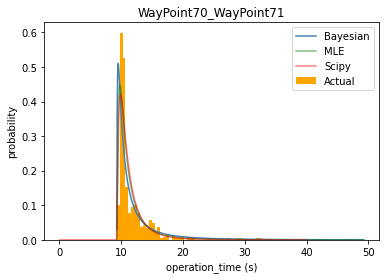

In [55]:
#Plot against actual data

t_start= 0.01
t_stop = (np.max(t_op)//5)*5 + 10    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes = Lognormal(t_test,mean_map,var_map)
p_ml = Lognormal(t_test,mean_ml,var_ml)
p_sp = sp.stats.lognorm.pdf(t_test, s = shape,loc = loc,scale = scale)

#plot
plt.plot(t_test+offset,p_bayes, color = "steelblue", alpha = 1)
plt.plot(t_test+offset,p_ml, color = "green", alpha = 0.5)
plt.plot(t_test,p_sp, color = "red", alpha = 0.5)
plt.hist(t_op, density = True, bins = 50, color = "orange")

plt.legend(["Bayesian", "MLE","Scipy","Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(edge)

## 2d) ks test

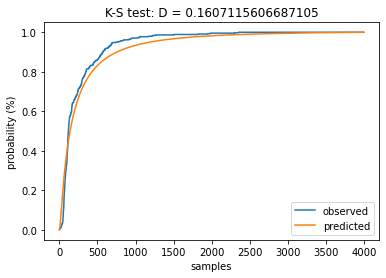

In [66]:
#ks test comparison
ks_bayes = error_ks(t_test+offset,p_bayes, t_op)

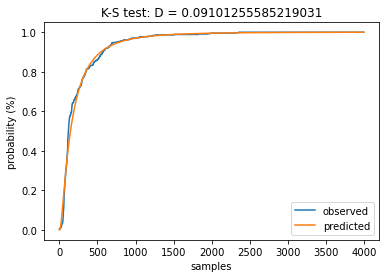

In [67]:
ks_ml = error_ks(t_test+offset,p_ml, t_op)

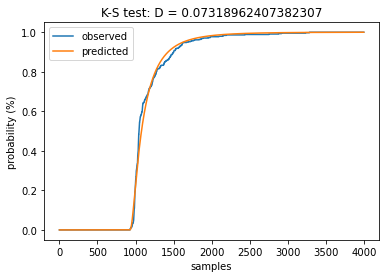

In [68]:
ks_sp = error_ks(t_test,p_sp, t_op)

# 3) Inverse Gaussian model